
## Image Captioning with Conditioned LSTM Generators



Student names:VENKATA SAINATH REDDY PALAVALA

Student IDs:1001949223


Follow the instructions in this notebook step-by step. Much of the code is provided, but some sections are marked with **TODO**. 

Specifically, you will build the following components: 

* Create matrices of image representations using an off-the-shelf image encoder.
* Read and preprocess the image captions. 
* Write a generator function that returns one training instance (input/output sequence pair) at a time. 
* Train an LSTM language generator on the caption data.
* Write a decoder function for the language generator. 
* Add the image input to write an LSTM caption generator. 
* Beam search to refine output captions.

Each group please submit one copy of this notebook only, including all outputs. 

Reference:
https://medium.com/@raman.shinde15/image-captioning-with-flickr8k-dataset-bleu-4bcba0b52926#:~:text=Captions%20are%20read%20from%20Flickr8k.token.txt%20file%20and%20stored,format%20%E2%80%9Cstartseq%20%E2%80%9C%20%2B%20caption%20%2B%20%E2%80%9C%20endseq%E2%80%9D

### Getting Started 

First, run the following commands to make sure you have all required packages. 

In [6]:
# tested with python 3.6
import os
import re
import tensorflow as tf
from collections import defaultdict
import numpy as np
import pandas as pd
import PIL
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
%matplotlib inline
from keras import Sequential, Model
from tensorflow.keras import layers
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from keras.activations import softmax
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from textwrap import wrap
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
# from google.colab import drive

seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

In [7]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


### Access to the flickr8k data

We will use the flickr8k data set, described here in more detail: 

> M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html

Dataset: https://www.kaggle.com/datasets/adityajn105/flickr8k

You need to download the dataset and then upload it again to your own drive. Please assign the name you choose for this folder to the variable `my_data_dir` in the next cell.


In [8]:
#this is where you put the name of your data folder.
#Please make sure it's correct because it'll be used in many places later.
my_data_dir="HW3"

### Mounting your GDrive so you can access the files from Colab (optional)

In [9]:
#running this command will generate a message that will ask you to click on a link where you'll obtain your GDrive auth code.
#copy paste that code in the text box that will appear below
dataset=("/content/gdrive/MyDrive/Hw3/")
print(dataset)

/content/gdrive/MyDrive/Hw3/


Please look at the 'Files' tab on the left side and make sure you can see the 'hw5_data' folder that you have in your GDrive.

## Part I: Understand the data (10 pts)

> Indented block



Read the caption file:

In [10]:
#intiallizing data "captions.txt to df for processing"
#"note::::: i have not only docked entire data but also added captions.txt for my drive seperately"

df = pd.read_csv(f'captions.txt')
print(df.shape)
df.head()

IMAGES_PATH = ("/content/gdrive/MyDrive/HW3/Images")

(40455, 2)


In [11]:
# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE #auto tune is used to tune the value dynamically

In [12]:
# this function 
#function for reading the image and then resizing and then displaying

# ref: https://www.geeksforgeeks.org/how-to-iterate-through-images-in-a-folder-python/
# ref: https://stackoverflow.com/questions/48001890/how-to-read-images-from-a-directory-with-python-and-opencv

def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img


def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/gdrive/MyDrive/HW3/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

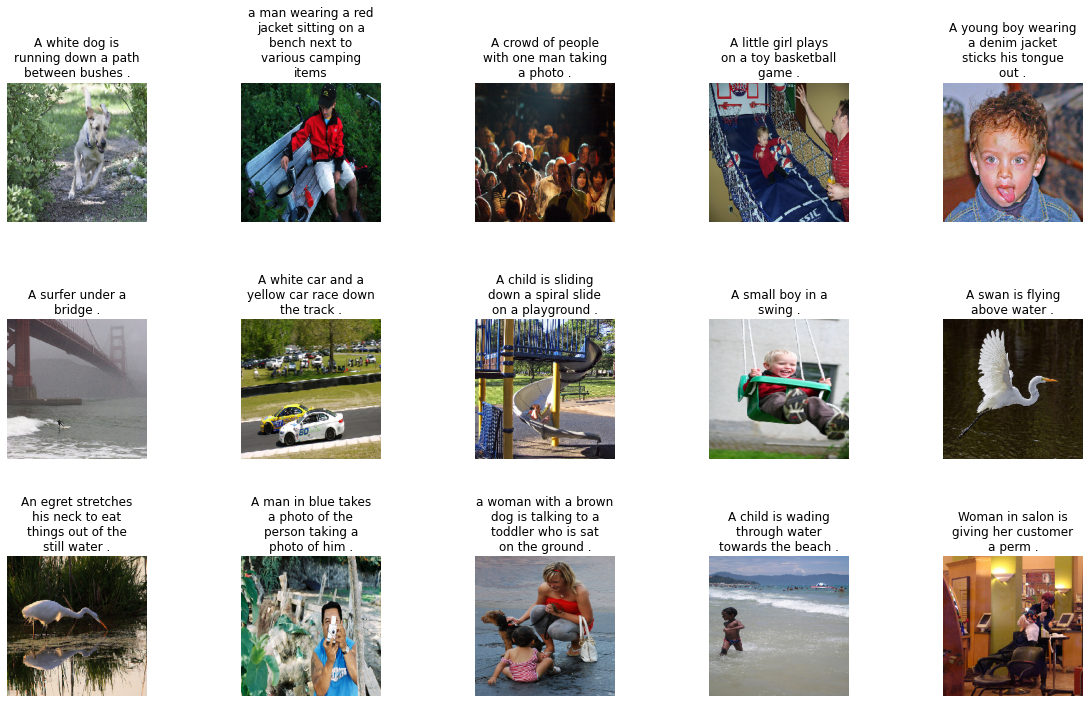

In [13]:
display_images(df.sample(15))

Train, test split:

In [14]:
#as intially we loaded thr data set right from that we are seperating the images and and its description using strip and split

def load_image_list(filename):
    with open(filename,'r') as image_list_f: 
        return [line.strip() for line in image_list_f]   

In [15]:
# text processing such as converting block letters and spaces

def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [16]:
# TODO: train, test split: 0.8: 0.2
# seperating from the above function and seting the captions to a list
data = text_preprocessing(df)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
# spliting training and testing 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.80*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

In [18]:
print(train)

                           image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
32360  3601569729_bf4bf82768.jpg   
32361  3601569729_bf4bf82768.jpg   
32362  3601569729_bf4bf82768.jpg   
32363  3601569729_bf4bf82768.jpg   
32364  3601569729_bf4bf82768.jpg   

                                                 caption  
0      startseq child in pink dress is climbing up se...  
1        startseq girl going into wooden building endseq  
2      startseq little girl climbing into wooden play...  
3      startseq little girl climbing the stairs to he...  
4      startseq little girl in pink dress going into ...  
...                                                  ...  
32360  startseq group of race horses run down track c...  
32361                         startseq horse race endseq  
32362      startseq jockeys on horse

In [19]:
print(test)

                           image  \
32365  3601803640_5f3cb05acf.jpg   
32366  3601803640_5f3cb05acf.jpg   
32367  3601803640_5f3cb05acf.jpg   
32368  3601803640_5f3cb05acf.jpg   
32369  3601803640_5f3cb05acf.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                 caption  
32365              startseq man and woman kissing endseq  
32366  startseq man and woman kissing in front of cro...  
32367               startseq man is kissing woman endseq  
32368  startseq young couple kiss while crowd mills i...  
32369         startseq two people kiss near crowd endseq  
...                                                  ...  
40450  startseq man in pink shirt climbs rock face en...  
40451  startseq man is rock climbing high in the air ...  
40452  startseq person in red shirt 

In [20]:
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

print(train)

                           image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
32360  3601569729_bf4bf82768.jpg   
32361  3601569729_bf4bf82768.jpg   
32362  3601569729_bf4bf82768.jpg   
32363  3601569729_bf4bf82768.jpg   
32364  3601569729_bf4bf82768.jpg   

                                                 caption  
0      startseq child in pink dress is climbing up se...  
1        startseq girl going into wooden building endseq  
2      startseq little girl climbing into wooden play...  
3      startseq little girl climbing the stairs to he...  
4      startseq little girl in pink dress going into ...  
...                                                  ...  
32360  startseq group of race horses run down track c...  
32361                         startseq horse race endseq  
32362      startseq jockeys on horse

In [21]:
print(train_images)

['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg', '1002674143_1b742ab4b8.jpg', '1003163366_44323f5815.jpg', '1007129816_e794419615.jpg', '1007320043_627395c3d8.jpg', '1009434119_febe49276a.jpg', '1012212859_01547e3f17.jpg', '1015118661_980735411b.jpg', '1015584366_dfcec3c85a.jpg', '101654506_8eb26cfb60.jpg', '101669240_b2d3e7f17b.jpg', '1016887272_03199f49c4.jpg', '1019077836_6fc9b15408.jpg', '1019604187_d087bf9a5f.jpg', '1020651753_06077ec457.jpg', '1022454332_6af2c1449a.jpg', '1022454428_b6b660a67b.jpg', '1022975728_75515238d8.jpg', '102351840_323e3de834.jpg', '1024138940_f1fefbdce1.jpg', '102455176_5f8ead62d5.jpg', '1026685415_0431cbf574.jpg', '1028205764_7e8df9a2ea.jpg', '1030985833_b0902ea560.jpg', '103106960_e8a41d64f8.jpg', '103195344_5d2dc613a3.jpg', '103205630_682ca7285b.jpg', '1032122270_ea6f0beedb.jpg', '1032460886_4a598ed535.jpg', '1034276567_49bb87c51c.jpg', '104136873_5b5d41be75.jpg', '1042020065_fb3d3ba5ba.jpg', '1042590306_95dea0916c.jpg', '1045521051_108ebc19b

In [22]:
print(test)

                          image  \
0     3601803640_5f3cb05acf.jpg   
1     3601803640_5f3cb05acf.jpg   
2     3601803640_5f3cb05acf.jpg   
3     3601803640_5f3cb05acf.jpg   
4     3601803640_5f3cb05acf.jpg   
...                         ...   
8085   997722733_0cb5439472.jpg   
8086   997722733_0cb5439472.jpg   
8087   997722733_0cb5439472.jpg   
8088   997722733_0cb5439472.jpg   
8089   997722733_0cb5439472.jpg   

                                                caption  
0                 startseq man and woman kissing endseq  
1     startseq man and woman kissing in front of cro...  
2                  startseq man is kissing woman endseq  
3     startseq young couple kiss while crowd mills i...  
4            startseq two people kiss near crowd endseq  
...                                                 ...  
8085  startseq man in pink shirt climbs rock face en...  
8086  startseq man is rock climbing high in the air ...  
8087  startseq person in red shirt climbing up rock ...  

In [23]:
tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

Each entry is an image filename.

In [24]:
train.head(5)

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  startseq child in pink dress is climbing up se...  
1    startseq girl going into wooden building endseq  
2  startseq little girl climbing into wooden play...  
3  startseq little girl climbing the stairs to he...  
4  startseq little girl in pink dress going into ...

Check an example:

(500, 375)
startseq two dogs on pavement moving toward each other endseq


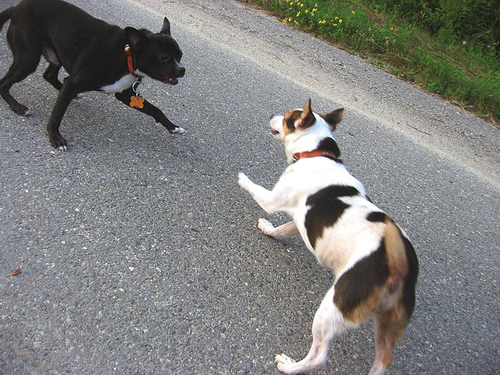

In [25]:
example_file = train.iloc[9]['image']
cap = train.iloc[9]['caption']
image = PIL.Image.open(os.path.join('/content/gdrive/MyDrive/HW3/Images', example_file))
print(image.size)
print(cap)
image

If you can't see the image, try

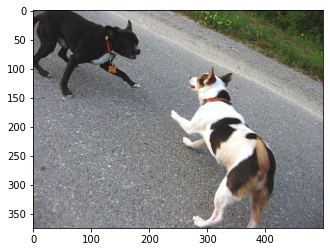

In [26]:
plt.imshow(image)

## Part II: Image encoder (10 pts)
We are going to use an off-the-shelf pre-trained image encoder, the Inception V3 network. The model is a version of a convolution neural network for object detection. Here is more detail about this model (not required for this project): 

> Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).
> https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html

The model requires that input images are presented as 299x299 pixels, with 3 color channels (RGB). The individual RGB values need to range between 0 and 1.0. The flickr images don't fit. 

In [27]:
np.asarray(image).shape

(375, 500, 3)

The values range from 0 to 255. 

In [29]:
np.asarray(image)

array([[[102, 103, 108],
        [ 95,  96, 101],
        [ 99, 100, 105],
        ...,
        [ 29,  29,  21],
        [ 31,  28,  23],
        [ 30,  25,  22]],

       [[108, 109, 114],
        [100, 101, 106],
        [ 94,  95, 100],
        ...,
        [ 37,  37,  29],
        [ 37,  34,  29],
        [ 33,  28,  25]],

       [[112, 112, 120],
        [118, 118, 126],
        [100, 100, 108],
        ...,
        [ 40,  40,  32],
        [ 37,  34,  29],
        [ 34,  31,  26]],

       ...,

       [[103, 101, 114],
        [104,  98, 110],
        [122, 114, 127],
        ...,
        [ 83,  88,  94],
        [ 76,  83,  89],
        [ 72,  79,  85]],

       [[111, 114, 121],
        [ 91,  88,  97],
        [ 85,  78,  86],
        ...,
        [ 95, 100, 106],
        [ 79,  84,  90],
        [ 79,  84,  90]],

       [[ 93,  96, 101],
        [ 69,  66,  73],
        [111, 101, 109],
        ...,
        [ 88,  91,  98],
        [ 82,  85,  92],
        [ 94,  99, 105]]

We can use PIL to resize the image and then divide every value by 255. 

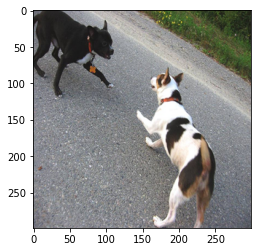

In [30]:
new_image = np.asarray(image.resize((299,299))) / 255.0
plt.imshow(new_image)

In [31]:
new_image.shape

(299, 299, 3)

In [32]:
img_path = "/content/gdrive/MyDrive/HW3/Images"

Let's put this all in a function for convenience. 

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
def read_image(image_name):
    image = PIL.Image.open(os.path.join(img_path, image_name))
    return np.asarray(image.resize((299,299))) / 255.0                     

In [34]:

def readImage(path="/content/gdrive/MyDrive/HW3/Images",img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

Next, we load the pre-trained Inception model. 

In [35]:
img_model = InceptionV3(weights='imagenet') # This will download the weight files for you and might take a while.

96112376/96112376 [==============================] - 1s 0us/step


In [36]:
img_model.summary() # this is quite a complex model. 

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

This is a prediction model,so the output is typically a softmax-activated vector representing 1000 possible object types. Because we are interested in an encoded representation of the image we are just going to use the second-to-last layer as a source of image encodings. Each image will be encoded as a vector of size 2048. 

We will use the following hack: hook up the input into a new Keras model and use the penultimate layer of the existing model as output.

In [37]:
new_input = img_model.input
new_output = img_model.layers[-2].output
img_encoder = Model(new_input, new_output) # This is the final Keras image encoder model we will use.

Let's try the encoder. 

In [38]:
encoded_image = img_encoder.predict(np.array([new_image]))

1/1 [==============================] - 4s 4s/step


In [39]:
encoded_image.shape

(1, 2048)

In [69]:
encoded_image

array([[0.7394507 , 0.5261144 , 0.15619549, ..., 0.02817826, 0.6911025 ,
        1.1200845 ]], dtype=float32)

**TODO:** We will need to create encodings for all images and store them in one big matrix (one for each dataset, train, test).
We can then save the matrices so that we never have to touch the bulky image data again. 

To save memory (but slow the process down a little bit) we will read in the images lazily using a generator. We will encounter generators again later when we train the LSTM. If you are unfamiliar with generators, take a look at this page: https://wiki.python.org/moin/Generators

Write the following generator function, which should return one image at a time. 
`img_list` is a list of image file names (i.e. the train, dev, or test set). The return value should be a numpy array of shape (1,299,299,3).

Now we can encode all images (this takes a few minutes).

In [39]:
# image generation and data encryption

In [40]:
def img_generator(img_list):
    # TODO: here
    for i in img_list:
      img_arr=read_image(i)
      yield np.array([img_arr])
      

In [41]:
enc_train = img_encoder.predict(img_generator(train_images), steps=len(train_images), verbose=1)

6473/6473 [==============================] - 1900s 293ms/step


In [42]:
enc_train.shape

(6473, 2048)

In [70]:
enc_train[100]

array([0.51036525, 0.54136187, 0.33679208, ..., 0.21623155, 0.37687892,
       0.08301333], dtype=float32)

In [129]:

enc_test = img_encoder.predict(img_generator(val_images), steps=len(val_images), verbose=1)

1618/1618 [==============================] - 386s 239ms/step


It's a good idea to save the resulting matrices, so we do not have to run the encoder again. 

In [44]:
np.save(f"encoded_images_train.npy", enc_train)
np.save(f"encoded_images_test.npy", enc_test)

## Part III Text (Caption) Data Preparation (10 pts)

Next, we need to load the image captions and generate training data for the generator model.

### Reading image descriptions

**TODO**: Write the following function that reads the image descriptions from the file `filename` and returns a dictionary in the following format. Take a look at the file `Flickr8k.token.txt` for the format of the input file. Data from https://github.com/text-machine-lab/MUTT/tree/master/data/flickr

The keys of the dictionary should be image filenames. Each value should be a list of 5 captions. Each caption should be a list of tokens.  

The captions in the file are already tokenized, so you can just split them at white spaces. You should convert each token to lower case. You should then pad each caption with a START token on the left and an END token on the right. 

In [70]:
# now we start descrpting the caption and dict to images and 
# "note:::" i sepearted the images and photos using ", (comma)" i didn't convert comma to ""

In [71]:
def read_image_descriptions(filename):    
    image_descriptions = defaultdict(list)    
    file_name = open(filename, 'r')
    for i in file_name:
      i = i.lower()
      name = i[:i.find(',')]
      cap = i[i.find(','):]
      cap = cap.strip('\t\n').split()
      cap.insert(0, '<START>')
      cap.append('<END>')
      image_descriptions[name].append(cap)
    return image_descriptions

In [131]:
P_PATH = os.path.join("/content/gdrive/MyDrive", my_data_dir)
print(P_PATH)
descriptions = read_image_descriptions(os.path.join(P_PATH, "captions.txt"))
descriptions

/content/gdrive/MyDrive/HW3


defaultdict(list,
            {'image': [['<START>', ',caption', '<END>']],
             '1000268201_693b08cb0e.jpg': [['<START>',
               ',a',
               'child',
               'in',
               'a',
               'pink',
               'dress',
               'is',
               'climbing',
               'up',
               'a',
               'set',
               'of',
               'stairs',
               'in',
               'an',
               'entry',
               'way',
               '.',
               '<END>'],
              ['<START>',
               ',a',
               'girl',
               'going',
               'into',
               'a',
               'wooden',
               'building',
               '.',
               '<END>'],
              ['<START>',
               ',a',
               'little',
               'girl',
               'climbing',
               'into',
               'a',
               'wooden',
               'playho

In [128]:
print(descriptions[train_images[100]])

[['<START>', ',a', 'black', 'and', 'white', 'border', 'collie', 'catches', 'a', 'frisbee', 'in', 'front', 'of', 'an', 'audience', '.', '<END>'], ['<START>', ',a', 'brown', 'and', 'white', 'dog', 'catches', 'a', 'frisbee', 'in', 'it', 'mouth', 'in', 'front', 'of', 'a', 'group', 'of', 'people', '.', '<END>'], ['<START>', ',a', 'brown', 'and', 'white', 'dug', 'jumping', 'up', 'to', 'catch', 'a', 'frisbee', 'while', 'an', 'audience', 'watches', '.', '<END>'], ['<START>', ',"a', 'dog', 'jumps', 'to', 'catch', 'a', 'frisbee', ',', 'while', 'many', 'people', 'watch', '."', '<END>'], ['<START>', ',an', 'agile', 'dog', 'catches', 'a', 'frisbee', 'while', 'a', 'crowd', 'of', 'onlookers', 'watches', 'closely', '.', '<END>']]


Running the previous cell should print similar to this:     
`[['<START>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<END>'], ['<START>', 'a', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '.', '<END>']]
`    

### Creating Word Indices

Next, we need to create a lookup table from the **training** data mapping words to integer indices, so we can encode input 
and output sequences using numeric representations. **TODO** create the dictionaries id_to_word and word_to_id, which should map tokens to numeric ids and numeric ids to tokens.  
Hint: Create a set of tokens in the training data first, then convert the set into a list and sort it. This way if you run the code multiple times, you will always get the same dictionaries. 

In [49]:
# TODO: 
# Creating the unique words list, using the set and list sort method
vocab = set()
for images, cap in descriptions.items():
  for i in cap:
    for X in i:
      vocab.add(X)


In [50]:
# TODO: 
# id_to_word = #...
# word_to_id = #...
vocab = sorted(list(vocab))
print(vocab)

['!', '!"', '""', '"""', '#', '&', "'", "'n'", "'s", "'s-eye-view", "'slide", '(', ')', ',', ',"', ',"a', ',"adults', ',"airborne', ',"amish', ',"an', ',"as', ',"asian', ',"at', ',"athlete', ',"average', ',"baby', ',"balck', ',"bald', ',"baseball', ',"basketball', ',"bearded', ',"behind', ',"bike', ',"bikers', ',"black', ',"blond', ',"bmx', ',"boy', ',"boys', ',"bright', ',"brightly', ',"brown', ',"catcher', ',"cheerleader', ',"child', ',"children', ',"closeup', ',"coach', ',"colorfully', ',"couple', ',"cricket', ',"crowded', ',"dark', ',"distant', ',"dog', ',"dogs', ',"during', ',"empty', ',"ever', ',"fireworks', ',"fisherman', ',"five', ',"football', ',"four', ',"girl', ',"girls', ',"gray', ',"gray-haired', ',"green', ',"greyhound', ',"group', ',"guys', ',"hockey', ',"hooded', ',"i', ',"in', ',"inside', ',"interesting', ',"jumping', ',"kids', ',"lady', ',"large', ',"laying', ',"little', ',"lone', ',"long-necked', ',"man', ',"many', ',"marathon', ',"men', ',"miami', ',"minivan', ',"mo

In [51]:
id_to_word = dict(enumerate(vocab))

In [52]:
word_to_id = {value: k for k, value in id_to_word.items()}

In [53]:
word_to_id['dog'] # should print an integer

3045

In [54]:
id_to_word[1985] # should print a token

'canal'

In [55]:
len(word_to_id)

9666

In [56]:
len(id_to_word[1985])

5

In [57]:
len(id_to_word)

9666

Note that we do not need an UNK word token because we are generating. The generated text will only contain tokens seen at training time.  

## Part IV Basic Decoder Model (20 pts)

For now, we will just train a model for text generation without conditioning the generator on the image input. 

There are different ways to do this and our approach will be slightly different from the generator discussed in class. 

The core idea here is that the Keras recurrent layers (including LSTM) create an "unrolled" RNN. Each time-step is represented as a different unit, but the weights for these units are shared. We are going to use the constant MAX_LEN to refer to the maximum length of a sequence, which turns out to be 40 words in this data set (including START and END).

In [58]:
max(len(description) for image_id in train_images for description in descriptions[image_id])

40

In class, we discussed LSTM generators as transducers that map each word in the input sequence to the next word. 
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm1.png" width="480px">

Instead, we will use the model to predict one word at a time, given a partial sequence. For example, given the sequence ["START","a"], the model might predict "dog" as the most likely word. We are basically using the LSTM to encode the input sequence up to this point. 
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm2.png" width="480px">


To train the model, we will convert each description into a set of input output pairs as follows. For example, consider the sequence 

`['<START>', 'a', 'black', 'dog', '.', '<END>']`

We would train the model using the following input/output pairs 

| i | input                        | output |
|---|------------------------------|--------|
| 0 |[`START`]                     | `a`    |  
| 1 |[`START`,`a`]                 | `black`|
| 2 |[`START`,`a`, `black`]        | `dog`  |
| 3 |[`START`,`a`, `black`, `dog`] | `END`  |



Here is the model in Keras Keras. Note that we are using a Bidirectional LSTM, which encodes the sequence from both directions and then predicts the output. 
Also note the `return_sequence=False` parameter, which causes the LSTM to return a single output instead of one output per state. 

$$p(x) = \Pi_1^{n}p(x_i | x_1, ..., x_{i-1}, img)$$

Note also that we use an embedding layer for the input words. The weights are shared between all units of the unrolled LSTM. We will train these embeddings with the model. 

In [59]:
MAX_LEN = 40
EMBEDDING_DIM=300
vocab_size = len(word_to_id)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Bidirectional(LSTM(512, return_sequences=False))(embedding)
pred = Dense(vocab_size, activation='softmax')(x)
model = Model(inputs=[text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 300)           2899800   
                                                                 
 bidirectional (Bidirectiona  (None, 1024)             3330048   
 l)                                                              
                                                                 
 dense (Dense)               (None, 9666)              9907650   
                                                                 
Total params: 16,137,498
Trainable params: 16,137,498
Non-trainable params: 0
_________________________________________________________________


The model input is a numpy ndarray (a tensor) of size `(batch_size, MAX_LEN)`. Each row is a vector of size MAX_LEN in which each entry is an integer representing a word (according to the `word_to_id` dictionary). If the input sequence is shorter than MAX_LEN, the remaining entries should be padded with 0. 

For each input example, the model returns a softmax activated vector (a probability distribution) over possible output words. The model output is a numpy ndarray of size `(batch_size, vocab_size)`. vocab_size is the number of vocabulary words. 

### Creating a Generator for the Training Data

**TODO**: 

We could simply create one large numpy ndarray for all the training data. Because we have a lot of training instances (each training sentence will produce up to MAX_LEN input/output pairs, one for each word), it is better to produce the training examples *lazily*, i.e. in batches using a generator (recall the image generator in part I). 

Write the function `text_training_generator` below, that takes as a paramater the batch_size and returns an `(input, output)` pair. `input` is a `(batch_size, MAX_LEN)` ndarray of partial input sequences, `output` contains the next words predicted for each partial input sequence, encoded as a `(batch_size, vocab_size)` ndarray.

Each time the next() function is called on the generator instance, it should return a new batch of the *training* data. You can use `train_list` as a list of training images. A batch may contain input/output examples extracted from different descriptions or even from different images. 

You can just refer back to the variables you have defined above, including `descriptions`, `train_list`, `vocab_size`, etc. 


Hint: To prevent issues with having to reset the generator for each epoch and to make sure the generator can always return exactly `batch_size` input/output pairs in each step, wrap your code into a `while True:` loop. This way, when you reach the end of the training data, you will just continue adding training data from the beginning into the batch. 

In [60]:
# TODO: data generator, intended to be used in a call to model.fit_generator()
# ref: https://www.clairvoyant.ai/blog/image-caption-generator
# ref: https://www.analyticsvidhya.com/blog/2021/12/step-by-step-guide-to-build-image-caption-generator-using-deep-learning/

In [61]:
def text_training_generator(batch_size=128):
    input_list = []
    output_list = []
    cnt = 0

    while True:
      for path in train_images:
        for cap in descriptions[path]:
          for i in range(len(cap)):
            cnt += 1

            if cnt < batch_size:
              vector = np.zeros(40, dtype = int)

              for j in range(i):
                vector[j] = word_to_id[cap[j]]

              if i == 0:
                continue
                
              input_list.append(vector)
              result_vector = np.zeros(vocab_size, dtype = int)
              result_vector[word_to_id[cap[j+1]]] = 1
              output_list.append(result_vector)

            else:
                input_arr = np.array(input_list)
                output_arr = np.array(output_list)

                yield (input_arr, output_arr)

### Training the Model

We will use the `fit_generator` method of the model to train the model. fit_generator needs to know how many iterator steps there are per epoch.

Because there are len(train_list) training samples with up to `MAX_LEN` words, an upper bound for the number of total training instances is `len(train_list)*MAX_LEN`. Because the generator returns these in batches, the number of steps is len(train_list) * MAX_LEN // batch_size

In [62]:
batch_size = 128
generator = text_training_generator(batch_size)
steps = len(train_images) * MAX_LEN // batch_size 

In [63]:
model.fit(generator, steps_per_epoch=steps, verbose=True, epochs=2)

Epoch 1/2
2022/2022 [==============================] - 4829s 2s/step - loss: 0.4033 - accuracy: 0.8533
Epoch 2/2
2022/2022 [==============================] - 4795s 2s/step - loss: 0.1681 - accuracy: 0.9153


Continue to train the model until you reach an accuracy of at least 40%. 

### Greedy Decoder

**TODO** Next, you will write a decoder. The decoder should start with the sequence `["<START>"]`, use the model to predict the most likely word, append the word to the sequence and then continue until `"<END>"` is predicted or the sequence reaches `MAX_LEN` words. 

In [72]:
def decoder():
    cap = ["<START>"]

    for i in range(MAX_LEN - 1):
      input_s = np.zeros(40, dtype = int)

      for i in range(len(cap)):
        input_s[i] = word_to_id[cap[i]]

      input_s = input_s.reshape(1, MAX_LEN)
      p = model.predict([input_s])
      pred = np.argmax(p)
      cap.append(id_to_word[pred])

      if id_to_word[pred] == "<END>":
        return " ".join(cap)
    

In [73]:
print(decoder())

1/1 [==============================] - 0s 53ms/step
<START> ,a black dog and a tri-colored dog playing with each other on the road . <END>


This simple decoder will of course always predict the same sequence (and it's not necessarily a good one). 

Modify the decoder as follows. Instead of choosing the most likely word in each step, sample the next word from the distribution (i.e. the softmax activated output) returned by the model. Take a look at the [np.random.multinomial](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multinomial.html) function to do this. 

In [91]:
def sample_decoder():
    #...
    list1=[]
    sequence1=[word_to_id["<START>"]]
    display1=["<START>"]
    while True:
      x=pad_sequences([sequence1],maxlen=MAX_LEN)[0]
      x=np.expand_dims(x, axis=0)
      pred_1=model.predict(x)
      pred_1=np.ravel(pred_1)
      the_id=np.where(pred_1==np.random.choice(pred_1))[0][0]
      wd=id_to_word[the_id]
      if wd=="<END>":
        display1.append(wd)
        break
      if len(display1)==MAX_LEN:
        break
      display1.append(wd)
      sequence1.append(the_id)

    return ' '.join(display1)
    return []

You should now be able to see some interesting output that looks a lot like flickr8k image captions -- only that the captions are generated randomly without any image input. 

In [92]:
for i in range(10): 
    print(sample_decoder())

1/1 [==============================] - 0s 56ms/step
<START> picutre ballons gear darker trailing formal spike stopping foldable ,hawaiian exercise involved cot gold mills circled silk pouting expanding involving baton villages flowers clothes" tune wetsuite snarls vandalized battons seal stringed six firends roman gondola fig inspect ,cute dodgeball
1/1 [==============================] - 0s 49ms/step
<START> shoulder-high mouthguards outfield victory produces guardsman fruits mattress well-groomed locking attampts deep offering jogged tying brazilian duel playing slowly googles numbered swoops cookies automobile horses lie 19 tale multi-story ,gold suburbs computer extinguish german labs pedestrian ,sooners landing ethnicity
1/1 [==============================] - 0s 50ms/step
<START> fort licked marble ritz dragging comfort eroded facepaintings slat tuxes sticking brwon ends knees surounded street" put building somehow musicans mid-jump involves mussels adhd starbuck life picture displ

## Part V - Conditioning on the Image (20 pts)

We will now extend the model to condition the next word not only on the partial sequence, but also on the encoded image. 

We will project the 2048-dimensional image encoding to a 300-dimensional hidden layer. 
We then concatenate this vector with each embedded input word, before applying the LSTM.

Here is what the Keras model looks like: 

In [93]:
MAX_LEN = 40
EMBEDDING_DIM=300
IMAGE_ENC_DIM=300


vocab_size = len(word_to_id)
# Image input
img_input = Input(shape=(2048,))
img_enc = Dense(300, activation="relu") (img_input)
images = RepeatVector(MAX_LEN)(img_enc)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Concatenate()([images,embedding])
y = Bidirectional(LSTM(256, return_sequences=False))(x) 
pred = Dense(vocab_size, activation='softmax')(y)
model1 = Model(inputs=[img_input,text_input],outputs=pred)
model1.compile(loss='categorical_crossentropy', optimizer="RMSProp", metrics=['accuracy'])

model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 300)          614700      ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 repeat_vector (RepeatVector)   (None, 40, 300)      0           ['dense_1[0][0]']                
                                                                                            

The model now takes two inputs: 
    
   1. a `(batch_size, 2048)` ndarray of image encodings. 
   2. a `(batch_size, MAX_LEN)` ndarray of partial input sequences. 
    
And one output as before: a `(batch_size, vocab_size)` ndarray of predicted word distributions.   

**TODO**: Modify the training data generator to include the image with each input/output pair. 
Your generator needs to return an object of the following format: `([image_inputs, text_inputs], next_words)`. Where each element is an ndarray of the type described above.  

You need to find the image encoding that belongs to each image. You can use the fact that the index of the image in `train_list` is the same as the index in enc_train and enc_dev. 

If you have previously saved the image encodings, you can load them from disk: 

In [94]:
enc_train = np.load("encoded_images_train.npy")

In [95]:
def training_generator(batch_size=128):
    input_list = []
    input_image = []
    output_list = []
    count = 0

    while True:
      for path in train_images:
        for cap in descriptions[path]:
          for i in range(len(cap)):

            count += 1
            if count < batch_size:
              vector = np.zeros(40, dtype = int)

              for j in range(i):
                vector[j] = word_to_id[cap[j]]
              if i == 0:
                continue

              input_image.append(enc_train[train_images.index(path)])
              input_list.append(vector)
              result_vector = np.zeros(vocab_size, dtype = int)
              result_vector[word_to_id[cap[j+1]]] = 1
              output_list.append(result_vector)

            else:
              input_arr = np.array(input_list)
              input_image = np.array(input_image)
              output_arr = np.array(output_list)
              yield ([input_image, input_arr], output_arr)


You should now be able to train the model as before: 

In [96]:
batch_size = 128
generator = training_generator(batch_size)
steps = len(train_images) * MAX_LEN // batch_size
print(generator) 

<generator object training_generator at 0x7f964600a7d0>


In [97]:
model1.fit(generator, steps_per_epoch=steps, verbose=True, epochs=3)

Epoch 1/3
2022/2022 [==============================] - 2629s 1s/step - loss: 0.5243 - accuracy: 0.8289
Epoch 2/3
2022/2022 [==============================] - 2577s 1s/step - loss: 0.1192 - accuracy: 0.9399
Epoch 3/3
2022/2022 [==============================] - 2534s 1s/step - loss: 0.1156 - accuracy: 0.9407


Again, continue to train the model until you hit an accuracy of about 40%. This may take a while. I strongly encourage you to experiment with cloud GPUs using the GCP voucher for the class. 

You can save your model weights to disk and continue at a later time. 

In [103]:
model1.save_weights("model.h5")

to load the model: 

In [104]:
model1.load_weights("model.h5")

**TODO**: Now we are ready to actually generate image captions using the trained model. Modify the simple greedy decoder you wrote for the text-only generator, so that it takes an encoded image (a vector of length 2048) as input, and returns a sequence.

In [158]:
def image_decoder(enc_image): 
    s = np.zeros((1, MAX_LEN), dtype = int)
    pre = '<START>'
    cap = []
    count = 0
    len = MAX_LEN-1

    while count < len and pre != "<END>":
      s[0][count] = word_to_id[pre]

      p = model1.predict([enc_image.reshape(1, 2048), s])

      word = id_to_word[np.argmax(p)]

      count += 1

      if word != pre:
        s[0][count] = word_to_id[word]
        cap.append(word)
        pre = word

    return " ".join(cap[:-1])  

1/1 [==============================] - 0s 37ms/step


',a little girl climbing into a wooden playhouse .'

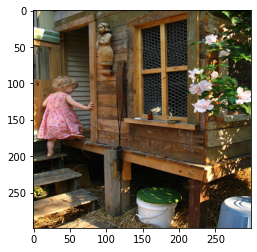

In [160]:
# Training image test-1
idx = 0
t = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_images[idx]))
image_decoder(t)

You should also be able to apply the model to dev images and get reasonable captions:

1/1 [==============================] - 0s 36ms/step


',a little girl climbing into tri-colored dog playing with each other on the .'

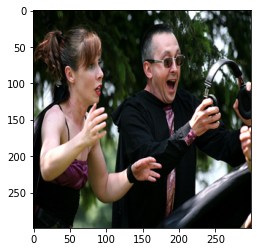

In [183]:
# Testing image test-1
idx = 10
t = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(val_images[idx]))
image_decoder(t)

## Part VII Beam search (10 pts)

**TODO**: Use beam search algorithm to refine the output captions.

Reference: https://keras.io/api/keras_nlp/utils/beam_search/

https://keras.io/examples/nlp/text_generation_gpt/

In [177]:
def img_beam_decoder(n, image):
  start = [word_to_id["<START>"]]
  start_wd = [[start, 0.0]]
  x=1

  while len(start_wd[0][0]) < MAX_LEN:

    temp = []
    for s in start_wd:

      sequ = pad_sequences([s[0]], maxlen = MAX_LEN, padding = 'post').reshape((1, MAX_LEN))
      p = model1.predict([image.reshape(1, 2048), sequ])
      wd_p = np.argsort(p[0])[-n:]

      for w in wd_p:
        next_cap, prob = s[0][:], s[1]
        next_cap.append(w)
        prob += p[0][w]
        temp.append([next_cap, prob])

    start_wd = temp
    start_wd = sorted(start_wd, reverse=False, key=lambda x: x[1])
    start_wd = start_wd[-n:]

  start_wd = start_wd[-1][0]
  CAPS = [id_to_word[i] for i in start_wd]

  return " ".join(CAPS[1:])

**TODO**: Randomly plot 10 images with captions from train set and test set each.

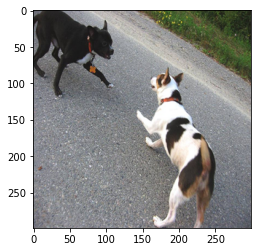

1/1 [==============================] - 0s 36ms/step
their greedy output:  ,a black dog and a tri-colored dog playing with each other on the road .
1/1 [==============================] - 0s 41ms/step
beam search at n=2:  ,a black dog and a tri-colored dog playing with each other on the road . <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> fighting <END> <END> a <END> <END> <END> a a <END> <END> a
1/1 [==============================] - 0s 35ms/step
beam search at n=3:  ,a black dog and a tri-colored dog playing with each other on the road . <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> fighting <END> <END> a <END> <END> <END> a a <END> <END> a
1/1 [==============================] - 0s 36ms/step
beam search at n=5:  ,a black dog and a white dog with brown spots are staring at each other in the street . <END> <END> <END> <END> <END> <END> <END> <END> <END> fighting <END> <END> <END> <END> <END> <END> <END> <END> <END> <END>
1/1 [==========

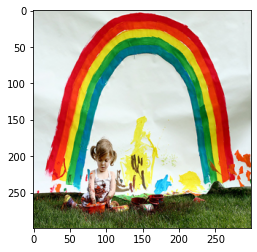

1/1 [==============================] - 0s 34ms/step
their greedy output:  ,a little girl climbing into tri-colored dog into with each other on the .
1/1 [==============================] - 0s 38ms/step
beam search at n=2:  ,a little girl climbing into spotted with with brown spots are staring at each other in the . <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END>
1/1 [==============================] - 0s 35ms/step
beam search at n=3:  ,a little girl climbing into tri-colored dog into with each other on the . <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> a <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END>
1/1 [==============================] - 0s 38ms/step
beam search at n=5:  ,a little girl climbing into tri-colored dog into with each other on the . <END> <END> <END> <END> <END> <END> the <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END

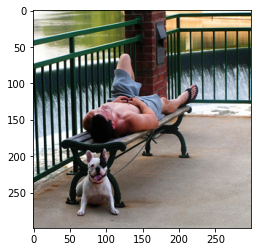

1/1 [==============================] - 0s 34ms/step
their greedy output:  ,a little girl climbing into tri-colored dog playing with each other on the .
1/1 [==============================] - 0s 37ms/step
beam search at n=2:  ,two dogs of different breeds looking at each other other on the . <END> <END> <END> <END> <END> ,a ,a ,a ,a ,a ,a at ,a at ,a a a <END> a the <END> <END> a <END> <END> a
1/1 [==============================] - 0s 37ms/step
beam search at n=3:  ,two dogs of different breeds looking at each other other other the the . <END> <END> <END> <END> <END> <END> <END> ,a ,a ,a ,a ,a ,a ,a ,a a a a <END> a <END> a <END> a <END>
1/1 [==============================] - 0s 34ms/step
beam search at n=5:  ,two dogs of different breeds looking at each other other other the the . <END> <END> <END> <END> <END> the <END> the <END> <END> <END> ,a ,a ,a ,a ,a ,a ,a ,a ,a a a <END> a <END>
1/1 [==============================] - 0s 36ms/step
beam search at n=5:  ,two dogs of different breed

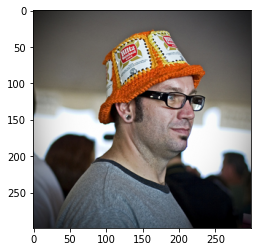

1/1 [==============================] - 0s 35ms/step
their greedy output:  ,a little girl climbing into a wooden playhouse .
1/1 [==============================] - 0s 37ms/step
beam search at n=2:  ,a child in a pink dress is climbing up a set of stairs in an entry way . <END> <END> <END> <END> <END> <END> <END> way <END> <END> <END> <END> <END> <END> <END> <END> dog <END> dog <END> <END>
1/1 [==============================] - 0s 35ms/step
beam search at n=3:  ,a child in a pink dress is climbing up a set of stairs in an entry way . <END> <END> <END> <END> <END> <END> <END> way <END> <END> <END> <END> <END> <END> <END> <END> dog <END> dog <END> <END>
1/1 [==============================] - 0s 40ms/step
beam search at n=5:  ,a child in a pink dress is climbing up a set of stairs in an entry way . <END> <END> <END> <END> <END> <END> way <END> <END> <END> <END> <END> <END> <END> <END> <END> dog <END> <END> dog <END>
1/1 [==============================] - 0s 36ms/step
beam search at n=5:  ,a

In [185]:
for i in range(1,5):
  plt.imshow(read_image(train_images[i]))
  plt.show()
  print("their greedy output: ", image_decoder(enc_train[i]))
  print("beam search at n=2: ", img_beam_decoder(2, enc_train[i]))
  print("beam search at n=3: ", img_beam_decoder(3, enc_train[i]))
  print("beam search at n=5: ", img_beam_decoder(4, enc_train[i]))
  print("beam search at n=5: ", img_beam_decoder(5, enc_train[i]))

# References:
https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html

https://studymachinelearning.com/text-preprocessing-removal-of-punctuations/

https://stackoverflow.com/questions/45634254/how-can-i-create-a-none-299-299-3-from-299-299-3

https://github.com/sy-lai/image-captioning/blob/main/flickr_caption_generator.ipynb

https://keras.rstudio.com/reference/predict_generator.html

https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays

https://stackoverflow.com/questions/71357014/running-a-fine-tune-model-for-my-cnn-value-error

https://www.clairvoyant.ai/blog/image-caption-generator

https://www.analyticsvidhya.com/blog/2021/12/step-by-step-guide-to-build-image-caption-generator-using-deep-learning/

https://www.geeksforgeeks.org/how-to-iterate-through-images-in-a-folder-python/

https://stackoverflow.com/questions/48001890/how-to-read-images-from-a-directory-with-python-and-opencv